## The aim 

Optimising Prussian White (PW) synthesis with aspect to final pH and time for addition of acid with respect to particle size and morphology. 

## How?

Create a simple 2x2 DoE with mid point to find a optimum for the output parameters in this pH-space. If time allows it, some follow up synthesis experiments will be done to reach a more global maximum. 

## Setting up DoE


In [114]:
#Import all packages 
import pandas as pd
import numpy as np
from numpy.random import rand
import itertools
from matplotlib.pyplot import *
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [115]:
# create dictionary for parameters
input_labels = {
    'A' : 'pH',                 #End pH of synthesis
    'B' : '%t'                   #Time in % of the total addition time 
}

# create list of data for high and low. 
data = [
    ('A',3.5,4,4.5),
    ('B',0,10,20),
]

# create pandas dataframe in a pandas dataframe
inputs_df = pd.DataFrame(data,columns=['index', 'low', 'center', 'high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : input_labels[z] )

#print dataframe
inputs_df

,low,center,high,label
index,,,,
A,3.5,4,4.5,pH
B,0.0,10,20.0,%t


In [116]:
#encode the raw data

# compute averages and span
inputs_df['average'] = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2 , axis=1)
inputs_df['span'] = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2 , axis=1)

# encode the data
inputs_df['encoded_low'] = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_center'] = inputs_df.apply( lambda z : ( z['center'] - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)

inputs_df = inputs_df.drop(['average','span'],axis=1)

inputs_df

,low,center,high,label,encoded_low,encoded_center,encoded_high
index,,,,,,,
A,3.5,4,4.5,pH,-1.0,0.0,1.0
B,0.0,10,20.0,%t,-1.0,0.0,1.0


In [117]:
#Create the design matrix for the experiment

encoded_inputs= list(itertools.product([-1,1],[-1,1]))
encoded_inputs

results=pd.DataFrame(encoded_inputs)
results=results[results.columns[::-1]]
results.columns=['A','B']
results.loc[len(results.index)] = [0,0]         #Add mid point to experiment
results

,A,B
0,-1,-1
1,1,-1
2,-1,1
3,1,1
4,0,0


In [118]:
#Translates the desing matrix into the experimental matrix 
#where we can see what experiments we need to do for a full factorial

real_experiment = results

var_labels = []
for var in ['A','B']:
    var_label = inputs_df.loc[var]['label']
    var_labels.append(var_label)
    real_experiment[var_label] = results.apply(
        lambda z : inputs_df.loc[var]['low'] if z[var]<0 else (inputs_df.loc[var]['high'] if z[var]>0 else inputs_df.loc[var]['center']), 
        axis=1)

print("The values of each real variable in the experiment are:")

results


The values of each real variable in the experiment are:


,A,B,pH,%t
0,-1,-1,3.5,0.0
1,1,-1,4.5,0.0
2,-1,1,3.5,20.0
3,1,1,4.5,20.0
4,0,0,4.0,10.0


## Experiment and data sampling 

Now the experiments are being done, powder is being synthesised. All samples will be analysed with XRD and SEM. The SEM images will then be processed visually to get numerical values of the mean particle size and distribution.

Experiments will not be done in random order due to saftey reasons, otherwise randomy generate in which order the synthesis would be done to reduce the bias that could affect the outcome. One type of bias in this case is the students proficiency at doing the synthesis which can affect what level of leakegaes, poor deoxidation etc. might occur. 



In [119]:
#Add all experimental data to a dataframe


data = pd.DataFrame()

# create dictionary for parameters
input_labels = {
    'A' : 'start pH',               #Start pH of synthesis
    'B' : 'end pH',                 #End pH of synthesis
    'C' : '%t',                     #Time in % of the total addition time, either 0 or 100
    'D' : 'conc [M]',               #Cocnentration of the 50ml Acid added
    'E' : 'Particle size',          #Particle size obtained by visual inspection of SEM images in micrometers
    'F' : 'Standard deviation'      #Standard deviation of particle size
}

# create list of synthesis data #OBS point being 0 is not measured
data = [
    ('A', 'x', 'x', 1.6, 3.7, 1.13, 1.75), 
    ('B', 'x', 4.82, 3.65, 2.81, 1.83, 1.77),
    ('C', 'x', 0, 0, 100, 0, 100),
    ('D', 'x', 0.0026, 0.50, 0.50, 1.6, 1.6),
    ('E', 0.6733, 0.5912, 0.3202, 0.5947, 3.7360, 0.7448),
    ('F', 0.2638, 0.2257, 0.1541, 0.3396, 2.5180, 0.4529)
]

# put data in a pandas dataframe
result = pd.DataFrame(data,columns=['index', 'ref', 'S1', 'S2', 'S3', 'S4', 'S5'])
result = result.set_index(['index'])
result['Parameter'] = result.index.map( lambda z : input_labels[z] )

#print results dataframe
print('The values of the real experiments conducted are pressented in the table below:')
result



The values of the real experiments conducted are pressented in the table below:


,ref,S1,S2,S3,S4,S5,Parameter
index,,,,,,,
A,x,x,1.6000,3.7000,1.130,1.7500,start pH
B,x,4.82,3.6500,2.8100,1.830,1.7700,end pH
C,x,0,0.0000,100.0000,0.000,100.0000,%t
D,x,0.0026,0.5000,0.5000,1.600,1.6000,conc [M]
E,0.6733,0.5912,0.3202,0.5947,3.736,0.7448,Particle size
F,0.2638,0.2257,0.1541,0.3396,2.518,0.4529,Standard deviation


In [120]:
#What data is relevant for analysis? Drop ref synthesis and S1 as we do not have a complete data set for it

R2 = pd.DataFrame({'Start_pH' : [1.6, 3.7, 1.13, 1.75],
                   'End_pH' : [3.65, 2.81, 1.83, 1.77],
                   't' : [0, 100, 0, 100],
                   'Particle_size' : [0.3202, 0.5947, 3.7360, 0.7448],
                   'Standard_deviation': [0.1541, 0.3396, 2.5180, 0.4529]})

R2



,Start_pH,End_pH,t,Particle_size,Standard_deviation
0,1.60,3.65,0,0.3202,0.1541
1,3.70,2.81,100,0.5947,0.3396
2,1.13,1.83,0,3.7360,2.5180
3,1.75,1.77,100,0.7448,0.4529


Text(0.5, 0.92, '3d-visualisation of obtained data')

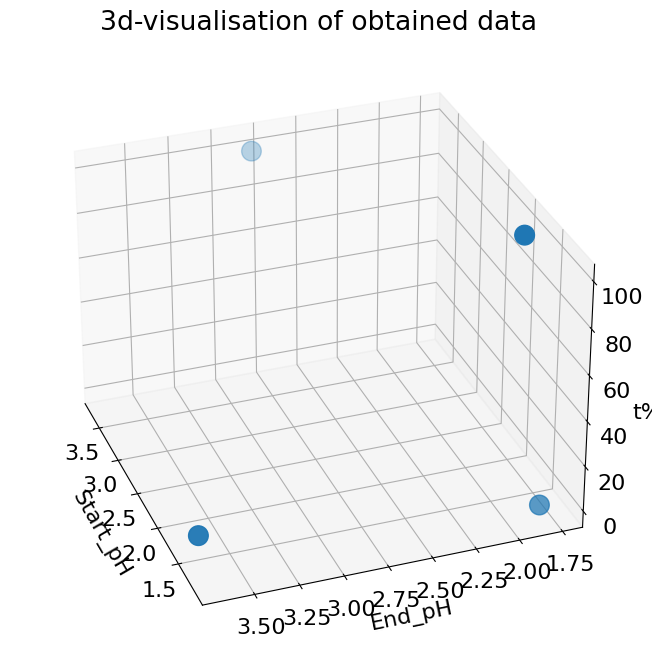

In [121]:
#The experiments done can be visualised in 3D

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 16})
# plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter3D(R2['Start_pH'],
             R2['End_pH'],
             R2['t'],
           s=200)
ax.set_xlabel('Start_pH')
ax.set_ylabel('End_pH')
ax.set_zlabel('t%');
ax.view_init(30, 160)
title('3d-visualisation of obtained data')
#plt.show()

## Data treatment and analysis


To use the experimental data to calculate the main effects, we first have to encode it for the function to work. The highest value of each parameter gets the encoding +1 and the lowest -1. Everything inbetween gets a numeric value inbetween. This is probably easily done with some sort of function but the ones we have used previosly did not work (since we dont have high/low in my case here) and I could not manage to adapt it to this situation. Therefore, I have manually done the encoding of my variables to be able to continue with the analysis part of this. 

In [122]:
R2_encoded = pd.DataFrame({'Start_pH' : [-0.6342, 1, -1, -0.5175],
                        'End_pH' : [1, 0.1064, -0.9362, -1],
                        't' : [-1, 1, -1, 1],
                        'Particle_size' : [0.3202, 0.5947, 3.7360, 0.7448],
                        'Standard_deviation': [0.1541, 0.3396, 2.5180, 0.4529]})

R2_encoded


,Start_pH,End_pH,t,Particle_size,Standard_deviation
0,-0.6342,1.0000,-1,0.3202,0.1541
1,1.0000,0.1064,1,0.5947,0.3396
2,-1.0000,-0.9362,-1,3.7360,2.5180
3,-0.5175,-1.0000,1,0.7448,0.4529


Now lets analyse the main effect of start pH, end pH and the time of addition of the acid (%t) on the particle size. This analysis is hard to do since we do not have a defined low and high state anymore. 

(How do we deal wiht this standard deviation from measurement?)


In [123]:
# Compute the mean effect of the factor on the response,
# conditioned on each variable
labels = ['Start_pH','End_pH','t']

average_main_effects = {}

for key in labels:
        average_effects = R2_encoded.groupby(key)['Particle_size'].mean()
        average_main_effects[key] = sum( [i*average_effects[i] for i in [-1,1]])
print(average_main_effects)


{'Start_pH': -3.1413, 'End_pH': -0.42460000000000003, 't': -1.3583500000000002}


2 way as in example (does not work due to encoding...)

In [124]:
#import itertools

#twoway_labels = list(itertools.combinations(labels, 2))


#twoway_effects = {}
#for key in twoway_labels:
    
#    effects = R2_encoded.groupby([key[0],key[1]])['Particle size'].mean()
#    twoway_effects[key] = sum([ i*j*effects[i][j]/4 for i in [-1,1] for j in [-1,1] ])

#twoway_effects

Since the performed experiments does not strictly fall in the experimental DoE, the results are also looked at with OLS from statsmodels. 


In [125]:
x = ['Start_pH','End_pH','t']
y = ['Particle_size']


#Ordinary least squares regression on parameters in x on parameter in y from the reduced eexperimental data table 
model_1 = sm.OLS(R2[y], R2[x])
res1 = model_1.fit()
print('Results of simple OLS:')
print(res1.summary())


Results of simple OLS:
                                 OLS Regression Results                                
Dep. Variable:          Particle_size   R-squared (uncentered):                   0.318
Model:                            OLS   Adj. R-squared (uncentered):             -1.730
Method:                 Least Squares   F-statistic:                             0.1551
Date:                Wed, 11 Oct 2023   Prob (F-statistic):                       0.915
Time:                        08:42:31   Log-Likelihood:                         -7.5508
No. Observations:                   4   AIC:                                      21.10
Df Residuals:                       1   BIC:                                      19.26
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

/home/aleul811/.local/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


In [126]:
#Model with more parameters
model2 = smf.ols(formula='Particle_size ~ Start_pH + End_pH + t + Start_pH:End_pH + End_pH:t + Start_pH:t + Start_pH:End_pH:t', data=R2)
res2 = model2.fit()
print('Results of model with more variables: ')
print(res2.summary())



Results of model with more variables: 
                            OLS Regression Results                            
Dep. Variable:          Particle_size   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 11 Oct 2023   Prob (F-statistic):                nan
Time:                        08:42:31   Log-Likelihood:                 114.34
No. Observations:                   4   AIC:                            -220.7
Df Residuals:                       0   BIC:                            -223.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------

/home/aleul811/.local/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/home/aleul811/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/aleul811/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/aleul811/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1716: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


From the fit with more variables,the ones giving the least impact are t, End_pH:t, Start_pH:t and Start_pH:End_pH:t. A model where these are excluded can be seen below:    

In [127]:
#Model with less parameters
model3 = smf.ols(formula='Particle_size ~ Start_pH + End_pH + Start_pH:End_pH', data=R2)
res3 = model3.fit()
print('Results of model with less variables: ')
print(res3.summary())


Results of model with less variables: 
                            OLS Regression Results                            
Dep. Variable:          Particle_size   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 11 Oct 2023   Prob (F-statistic):                nan
Time:                        08:42:31   Log-Likelihood:                 122.31
No. Observations:                   4   AIC:                            -236.6
Df Residuals:                       0   BIC:                            -239.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Int

/home/aleul811/.local/lib/python3.10/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/home/aleul811/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/aleul811/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1794: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/home/aleul811/.local/lib/python3.10/site-packages/statsmodels/regression/linear_model.py:1716: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


Plot the function that the OLS gives:

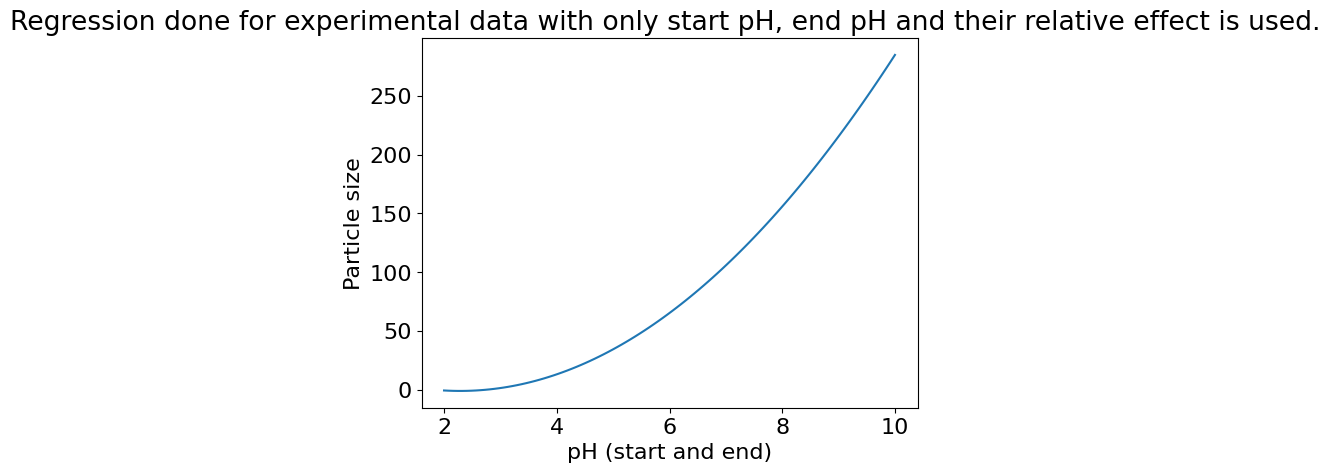

In [128]:
a = np.linspace(2,10,100)
b=  np.linspace(2,10,100)

def func(a, b):

    y = -13.5811*a -8.2963*b + 4.7895*a*b + 24.3606
    return(y)

y=func(a, b)


#plottning
plt.plot(a, y) #since a and b are the same in this case, I'll only plot it vs a. 

# Defining the plot title, x and y labels
plt.title('Regression done for experimental data with only start pH, end pH and their relative effect is used. ')
plt.xlabel('pH (start and end)')
plt.ylabel('Particle size')

plt.show()




From this graph, we would getter bigger particles, the higher pH we have - which is not what we have seen in the experiment. The analyssis of the data or the models themselfs lack something. To few data points and not following the DoE made analysis harder. 